In [1]:
import torch

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

In [2]:
# 如果没有文件夹就创建一个文件夹
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

### 超参数设置

In [26]:
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 200
batch_size = 128
learning_rate = 1e-3

### 数据集读取

In [40]:
dataset = torchvision.datasets.MNIST(root='../../../data/minist',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# 数据加载器
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

### 模型建立

In [6]:
# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim) # 均值 向量
        self.fc3 = nn.Linear(h_dim, z_dim) # 保准方差 向量
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    # 编码过程
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    # 随机生成隐含向量
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    # 解码过程
    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    
    # 整个前向传播过程：编码-》解码
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

### 初始化

In [27]:
# 实例化一个模型
model = VAE()
# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 模型训练

In [ ]:
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # 获取样本，并前向传播

        x = x.view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # 计算重构损失和KL散度（KL散度用于衡量两种分布的相似程度）
        # KL散度的计算可以参考论文或者文章开头的链接
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # 反向传播和优化
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
    
    # 利用训练的模型进行测试
    with torch.no_grad():
        # 随机生成的图像
        z = torch.randn(batch_size, z_dim)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # 重构的图像
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

### 结果可视化展示

In [21]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

### 随机生成的图片生成效果展示

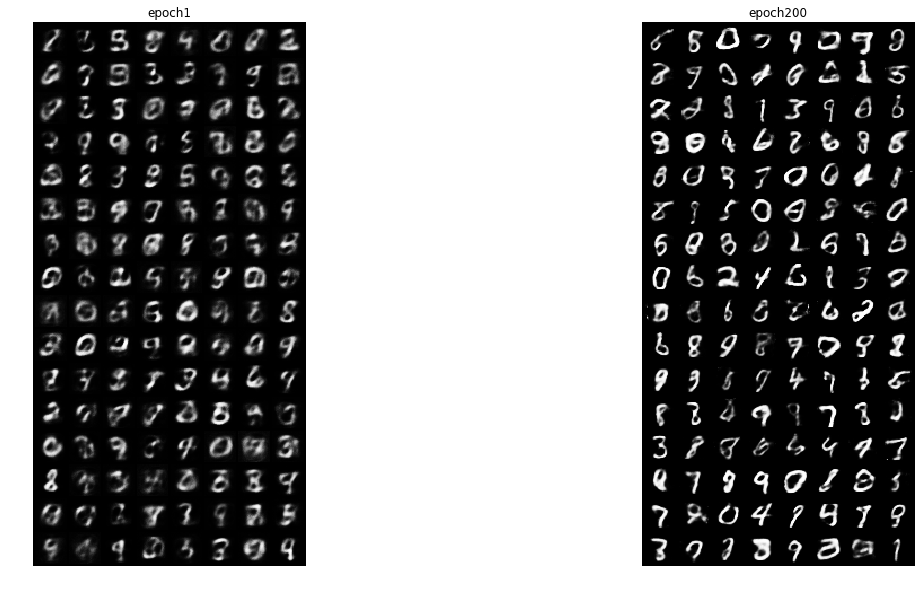

In [49]:
sampledPath1 = './samples/sampled-1.png'
sampledImage1 = mpimg.imread(sampledPath1)

sampledPath200 = './samples/sampled-200.png'
sampledImage200 = mpimg.imread(sampledPath200)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1 ) # 显示图片
plt.title("epoch1")
plt.imshow(sampledImage1) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.subplot(1,2,2 ) # 显示图片
plt.title("epoch200")
plt.imshow(sampledImage200) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

### 使用原始图像进行重构的样本效果展示

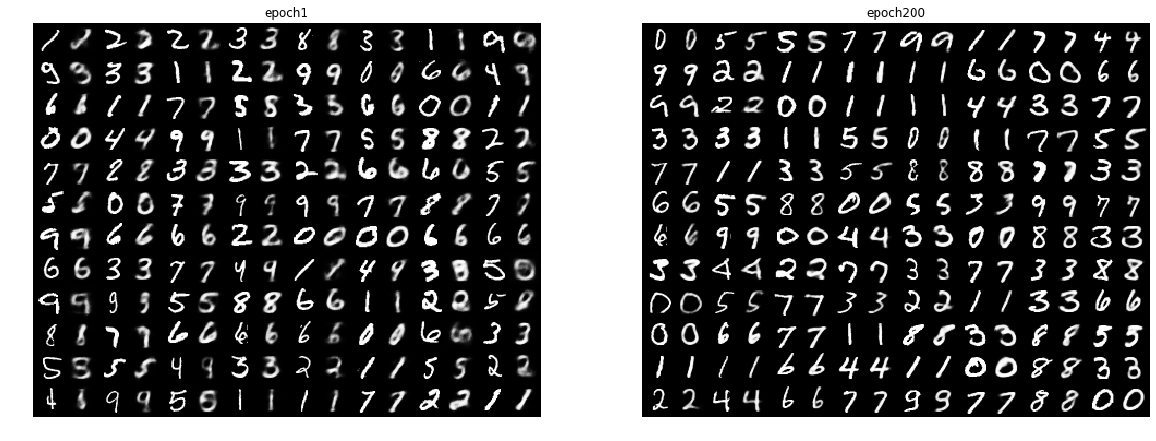

In [47]:
reconsPath1 = './samples/reconst-1.png'
reconsImage1 = mpimg.imread(reconsPath1)

reconsPath200 = './samples/reconst-200.png'
reconsImage200 = mpimg.imread(reconsPath200)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1 ) # 显示图片
plt.title("epoch1")
plt.imshow(reconsImage1) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.subplot(1,2,2 ) # 显示图片
plt.title("epoch200")
plt.imshow(reconsImage200) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()